# 10+ weeks of GSoC

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from time import sleep
from requests_html import HTMLSession

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams.update({'font.size': 13})

In [3]:
def annotate_barplot(ax):
    for p in ax.patches:
        val = f"{p.get_height():0.1f}"
        xpos = p.get_x()
        ypos = p.get_height() * 1.05
        ax.annotate(val, (xpos, ypos))

def extract_report(start_date, end_date, project_id, api_token, page=1):
    url_details = "https://api.track.toggl.com/reports/api/v2/details"
    params = {
        "user_agent": mail,
        "workspace_id": workspace_id,
        "since": start_date,
        "until": end_date,
        "page": page,
        "project_ids": project_id
    }
    r = requests.get(url_details, params=params, auth=(api_token, "api_token"))
    r.raise_for_status()
    
    return r

In [4]:
api_token = os.environ["TOGGL_API_TOKEN"]
password = os.environ["TOGGL_PASSWORD"]
mail = "g.duran@me.com"

In [5]:
headers = {
    "Content-Type": "application/json"
}

In [6]:
url_me = "https://api.track.toggl.com/api/v8/me"
r = requests.get(url_me, headers=headers, auth=(mail, password))
data = r.json()["data"]
print(data["fullname"], data["created_at"])

Gerardo Durán 2015-04-28T02:55:50+00:00


## Get workspaces

In [8]:
url_workspace = "https://api.track.toggl.com/api/v8/workspaces"
r = requests.get(url_workspace, headers=headers, auth=(mail, password))
# position 0 is Personal workspace
workspace_id = r.json()[0]["id"]
workspace_id

921814

## Get workspace projects

In [10]:
url_projects = f"https://api.track.toggl.com/api/v8/workspaces/{workspace_id}/projects"
r = requests.get(url_projects, headers=headers, auth=(mail, password))

ml_project, *_ = [project for project in r.json() if project["name"] == "GSoC"]
ml_project

{'id': 168628634,
 'wid': 921814,
 'name': 'GSoC',
 'billable': False,
 'is_private': True,
 'active': True,
 'template': False,
 'at': '2021-07-08T14:13:55+00:00',
 'created_at': '2021-03-29T19:49:57+00:00',
 'color': '8',
 'auto_estimates': False,
 'actual_hours': 399,
 'hex_color': '#465bb3'}

## My Time Entries

In [11]:
# Kick-off meeting to date of analysis
time_ranges = ["2021-05-24", "2021-08-15"]
time_ranges = [(init, end) for init, end in zip(time_ranges[:-1], time_ranges[1:])]

In [12]:
total_entries = []
for start_date, end_date in tqdm(time_ranges):
    info = extract_report(start_date, end_date, ml_project["id"], api_token).json()
    entries, per_page_entries = info["total_count"], info["per_page"]
    n_pages = entries // per_page_entries + 1
    total_entries.extend(info["data"])
    sleep(1)
    for page in tqdm(range(2, n_pages + 1), leave=False):
        info = extract_report(start_date, end_date, ml_project["id"], api_token, page=page).json()
        total_entries.extend(info["data"])
        sleep(1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
# Total number of times GSoC was toggl'd
len(total_entries)

333

# GSoC

In [15]:
gsoc = pd.DataFrame(total_entries).set_index("start")
# gsoc = gsoc[gsoc.description.str.contains("^[Bb]ishop")].sort_index()
gsoc.index = pd.to_datetime(gsoc.index, utc=True).tz_convert("Europe/London")
gsoc = gsoc.sort_index()
gsoc.head()

,id,pid,tid,uid,description,end,updated,dur,user,use_stop,client,project,project_color,project_hex_color,task,billable,is_billable,cur,tags
start,,,,,,,,,,,,,,,,,,,
2021-05-24 15:26:30+01:00,2023310839,168628634,None,1670359,Kick off meeting,2021-05-24T16:41:18+01:00,2021-05-24T21:24:10+01:00,4488000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[meetings]
2021-05-24 21:28:34+01:00,2023834170,168628634,None,1670359,Issue #61,2021-05-24T21:34:44+01:00,2021-05-24T21:34:45+01:00,370000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[Programming]
2021-05-24 22:30:54+01:00,2023900016,168628634,None,1670359,Issue #20,2021-05-25T00:03:36+01:00,2021-05-25T00:03:36+01:00,5562000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[Programming]
2021-05-25 10:20:45+01:00,2024578414,168628634,None,1670359,Mails,2021-05-25T10:30:04+01:00,2021-05-25T10:30:05+01:00,559000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[management]
2021-05-25 15:35:56+01:00,2025172276,168628634,None,1670359,Daily meeting,2021-05-25T16:06:46+01:00,2021-05-25T17:18:02+01:00,1850000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[meetings]


## Temporal Analysis

In [16]:
# Date of the first time entry
gsoc.index.min().strftime("%Y-%m-%d")

'2021-05-24'

In [17]:
# Total time of tracked worked 
days_study = gsoc.index.max() - gsoc.index.min()
days_study

Timedelta('83 days 03:47:48')

In [18]:
# Total number of hours worked
gsoc["clocked_hours"] = gsoc["dur"] * 0.001 / 60 ** 2
total_hours = gsoc["clocked_hours"].sum()
total_hours

394.86594611111116

In [19]:
gsoc["description"] = gsoc["description"].str.lower()
gsoc["description"]

start
2021-05-24 15:26:30+01:00    kick off meeting
2021-05-24 21:28:34+01:00           issue #61
2021-05-24 22:30:54+01:00           issue #20
2021-05-25 10:20:45+01:00               mails
2021-05-25 15:35:56+01:00       daily meeting
                                   ...       
2021-08-14 09:30:33+01:00          issue #358
2021-08-14 16:17:33+01:00          issue #358
2021-08-14 17:55:18+01:00          issue #358
2021-08-14 19:03:55+01:00          issue #358
2021-08-15 19:14:18+01:00          issue #366
Name: description, Length: 333, dtype: object

In [20]:
clocked_hours = (gsoc[["description", "clocked_hours"]]
                      .groupby("description")
                       .sum()
                       .sort_values("clocked_hours", ascending=False))
clocked_hours.head()

,clocked_hours
description,
daily meeting,52.231111
issue #54,38.633056
issue #279,30.807500
issue #40,27.674722
issue #299,18.192778


In [22]:
# Percentage of time working on issues
map_issues = clocked_hours.index.str.contains("#")
clocked_hours[map_issues].sum() / total_hours

clocked_hours    0.755478
dtype: float64

### Total time

<AxesSubplot:ylabel='Count'>

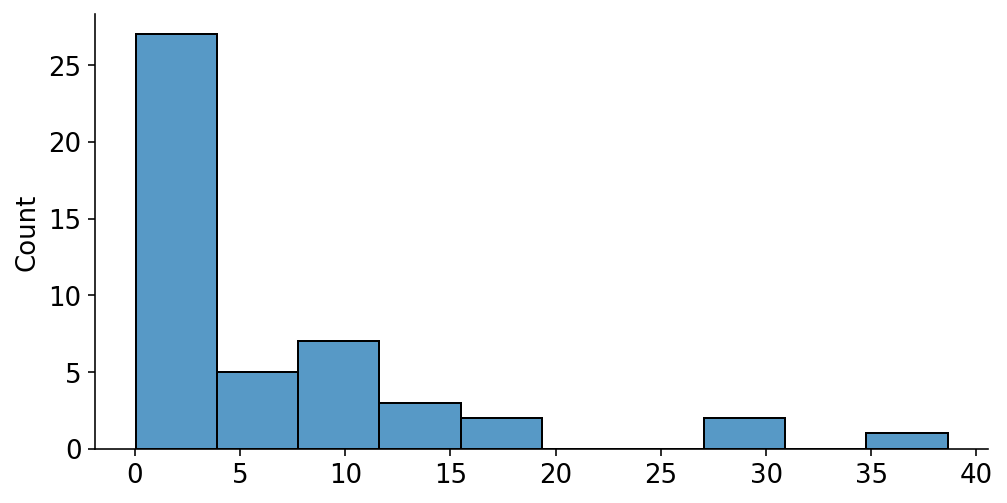

In [25]:
sns.histplot(clocked_hours[map_issues].values.ravel(), bins=10)

In [1184]:
weekly_commitment = gsoc.resample("W")[["clocked_hours"]].sum() 
weekly_commitment.index = weekly_commitment.index.values.astype("datetime64[D]")
weekly_commitment.index.name = "end of week"
weekly_commitment = weekly_commitment.reset_index()
weekly_commitment.index.name = "week"
print(weekly_commitment.to_string())

     end of week  clocked_hours
week                           
0     2021-05-29      23.183056
1     2021-06-05      43.937778
2     2021-06-12      39.890833
3     2021-06-19      28.637222
4     2021-06-26      34.411111
5     2021-07-03       8.668333
6     2021-07-10      39.891111
7     2021-07-17      26.115556
8     2021-07-24      36.937222
9     2021-07-31      35.834722
10    2021-08-07      42.378611
11    2021-08-14      34.980391


In [27]:
# Weekly commitment
gsoc.resample("W")["clocked_hours"].sum().mean()

32.90549550925926

In [28]:
gsoc.resample("M")["clocked_hours"].sum()

start
2021-05-31 00:00:00+01:00     30.657222
2021-06-30 00:00:00+01:00    144.213333
2021-07-31 00:00:00+01:00    142.636389
2021-08-31 00:00:00+01:00     77.359002
Freq: M, Name: clocked_hours, dtype: float64

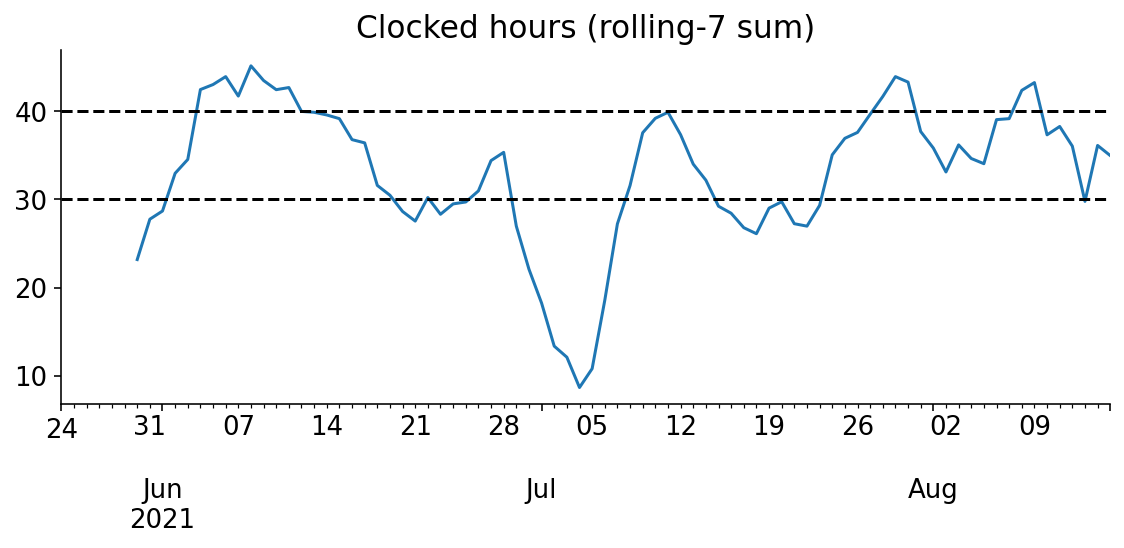

In [1213]:
gsoc.resample("D")["clocked_hours"].sum().rolling(7).sum().plot()
plt.axhline(y=40, c="black", linestyle="--")
plt.axhline(y=30, c="black", linestyle="--")
plt.title("Clocked hours (rolling-7 sum)")
plt.xlabel("")
plt.tight_layout()
plt.savefig("/Users/gerardoduran/Desktop/rolling-weekly-work.png", dpi=150)

In [1021]:
daily = gsoc.resample("D")[["clocked_hours"]].sum()
hours_per_weekday = daily.assign(weekday=daily.index.weekday).groupby("weekday")["clocked_hours"]
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

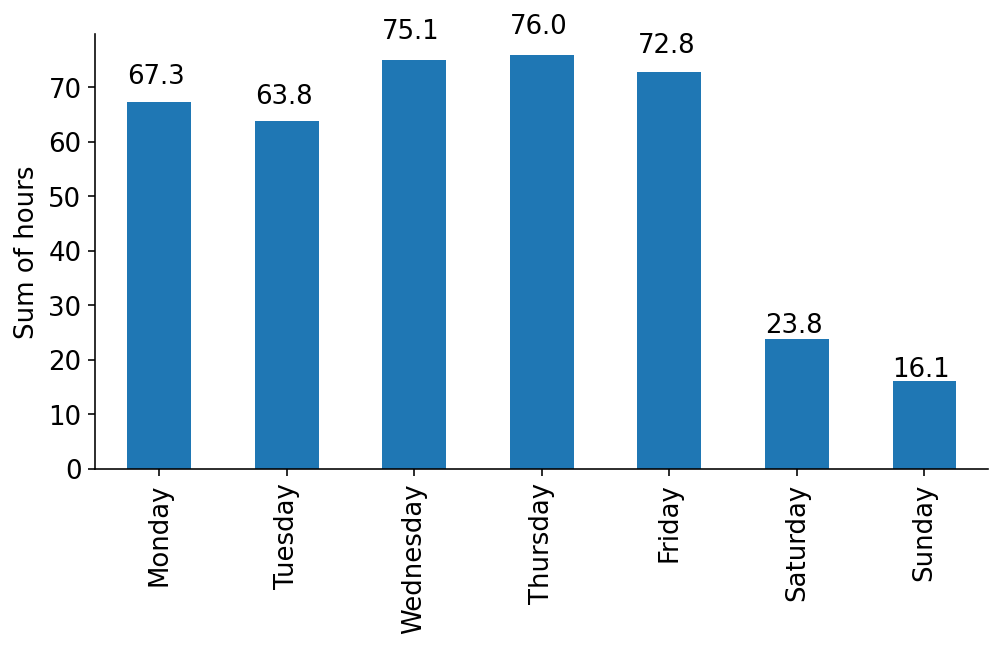

In [1022]:
sum_hours_per_weekday = hours_per_weekday.sum()
sum_hours_per_weekday.index = weekdays
ax = sum_hours_per_weekday.plot(kind="bar")
annotate_barplot(ax)
ax.set_ylabel("Sum of hours");

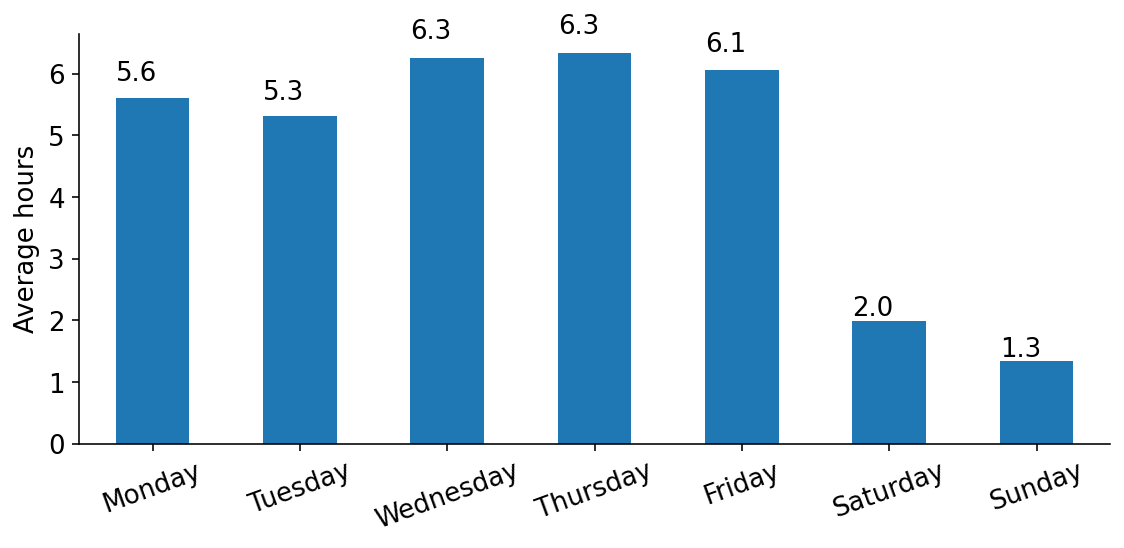

In [1148]:
mean_hours_per_weekday = hours_per_weekday.mean()
mean_hours_per_weekday.index = weekdays
ax = mean_hours_per_weekday.plot(kind="bar")
annotate_barplot(ax)
ax.set_ylabel("Average hours")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.tight_layout()
plt.savefig("/Users/gerardoduran/Desktop/avg-hours.png", dpi=150)

In [1158]:
mean_hours_per_weekday.iloc[:-2].mean()

5.916458333333333

In [33]:
start_values = gsoc.reset_index()[["start", "clocked_hours"]]
start_values["weekday"] = start_values["start"].apply(lambda v: v.weekday())
start_values["time"] = start_values["start"].apply(lambda v: v.hour + v.minute / 60)

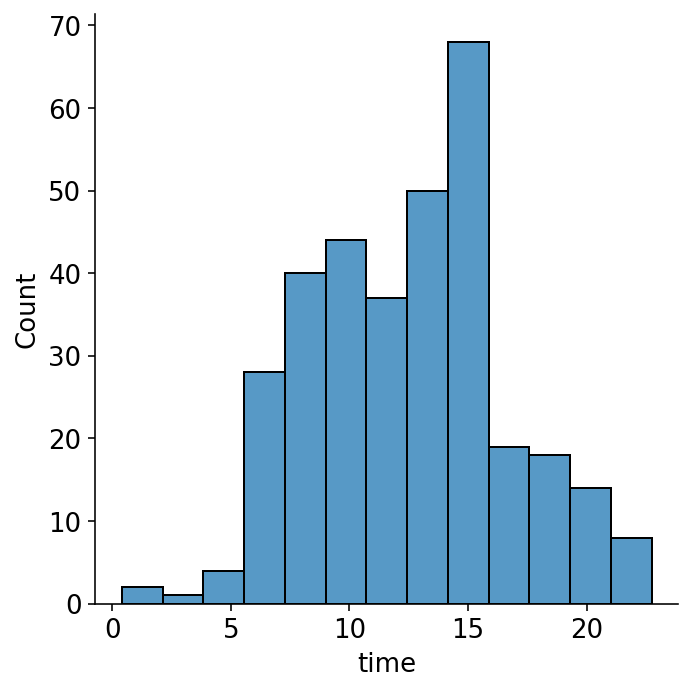

In [34]:
sns.displot(start_values, x="time")

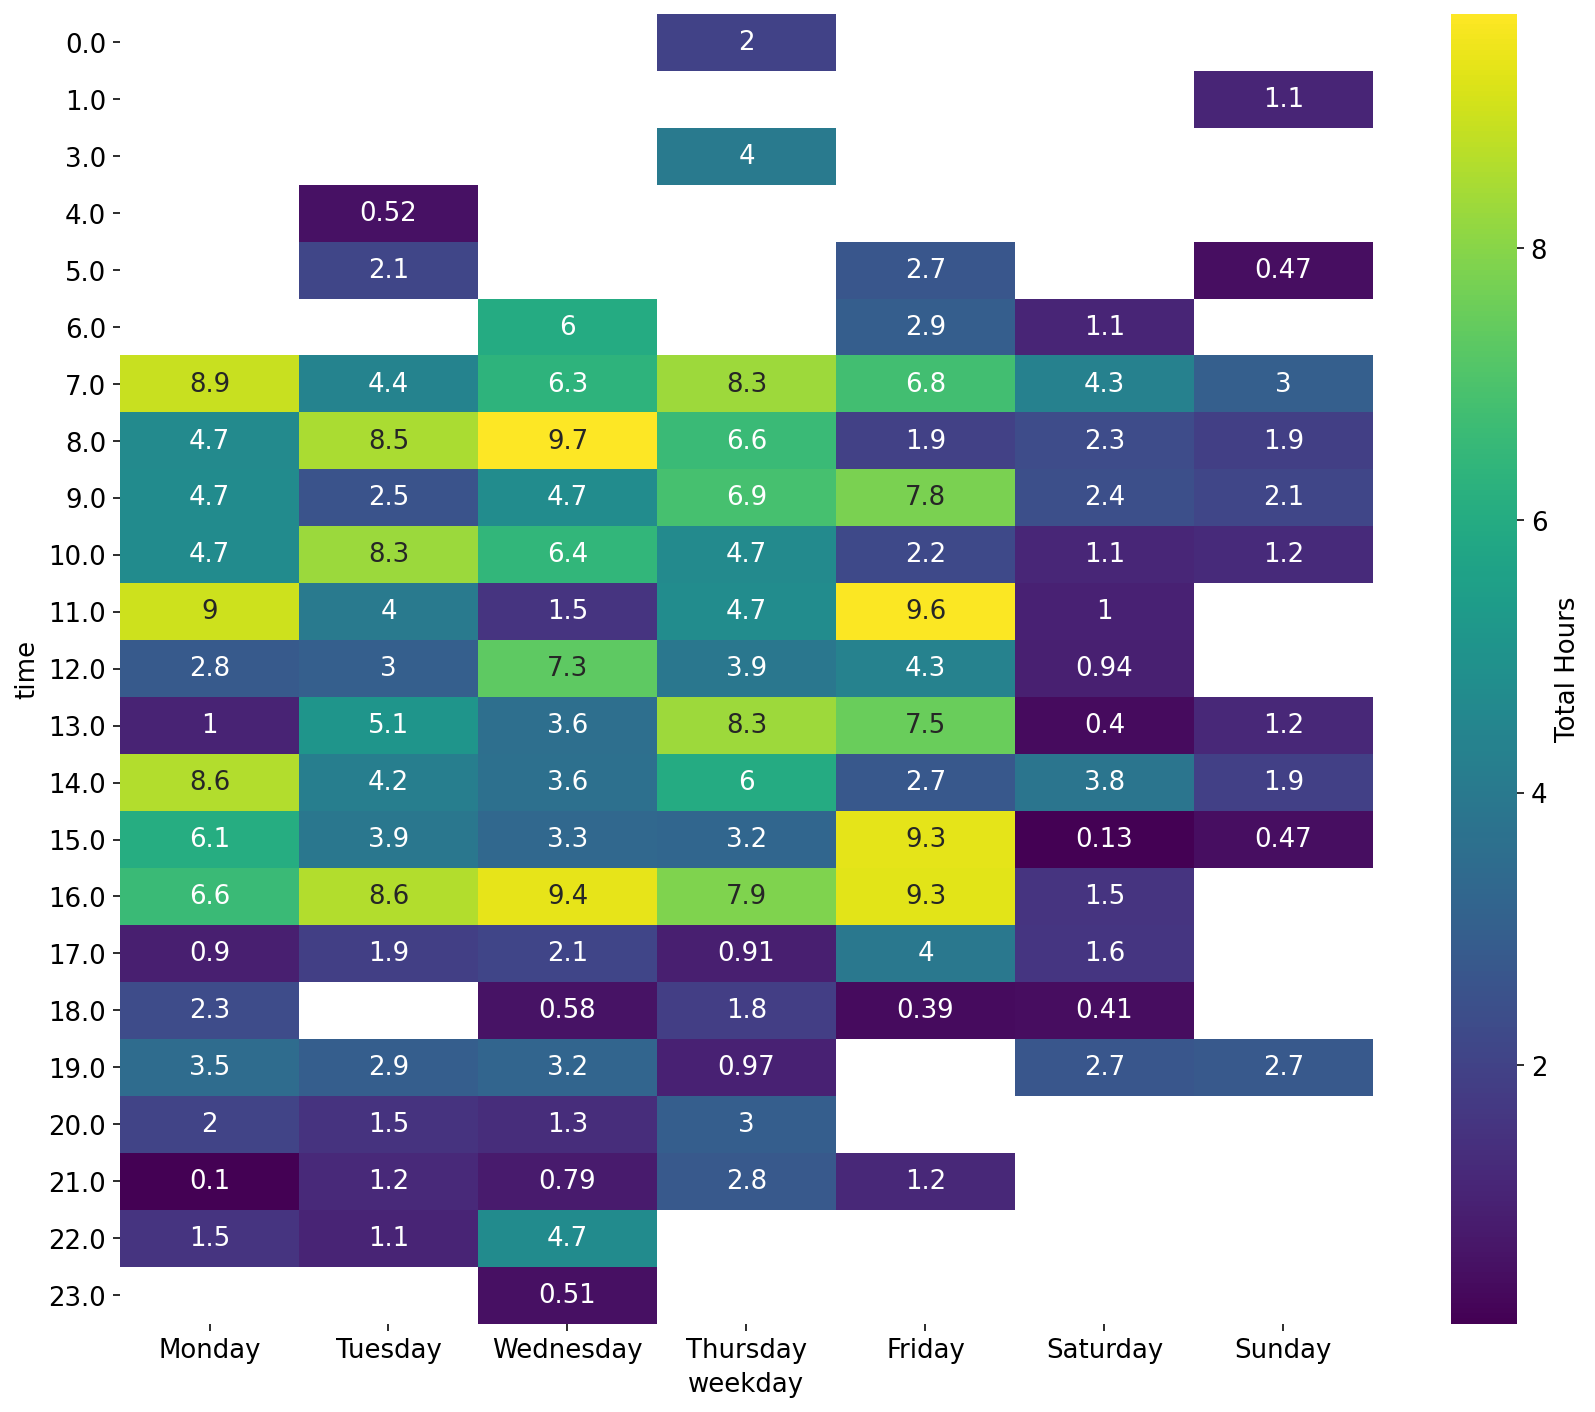

In [36]:
time_distribution = (start_values.assign(time=start_values.time.round(0))
                                 .pivot_table(columns="weekday", index="time",
                                              values="clocked_hours", aggfunc="sum"))
time_distribution
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(time_distribution, annot=True, cmap="viridis",
            xticklabels=weekdays, cbar_kws={"label": "Total Hours"})
plt.tight_layout()

## Issue analysis

In [ ]:
from datetime import datetime
from github import Github
from IPython.display import display, HTML, Markdown, Video
pd.set_option("display.max_colwidth", 100)

public_access_token = os.environ["GH_PUBLIC_ACCESS_TOKEN"]
g = Github(public_access_token)
hermes_repo = g.get_repo("probml/hermes")

In [338]:
clocked_issues = clocked_hours[map_issues]
# Set as index the number of the issue
clocked_issues.index = clocked_issues.index.str.extract("#([0-9]+)")[0].values.astype(int)
clocked_issues.describe().T

,count,mean,std,min,25%,50%,75%,max
clocked_hours,47.0,6.347077,8.345189,0.051389,0.818333,2.864722,8.54125,38.633056


In [339]:
gsoc_issues = gsoc[gsoc.description.str.contains("#")]
gsoc_issues = gsoc_issues[["description", "clocked_hours"]]
gsoc_issues["issue_number"] = gsoc_issues.description.str.extract("#([0-9]+)").astype(int)

issues_names = gsoc_issues.description
issues_names = issues_names.str.extract("#([0-9]+)")[0].unique().astype(int)

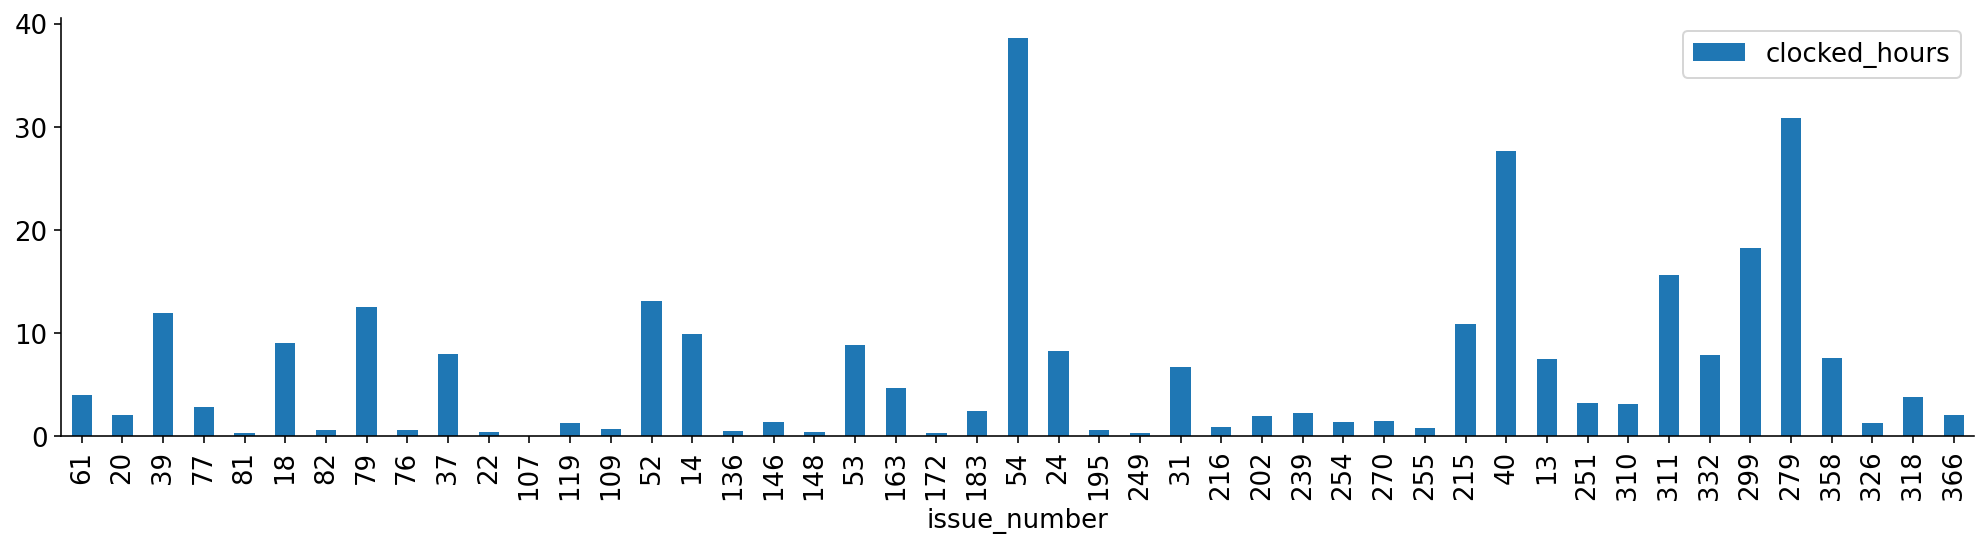

In [1149]:
fig, ax = plt.subplots(figsize=(14, 4))
gsoc_issues_summ = gsoc_issues.groupby("issue_number").sum().reindex(issues_names)
gsoc_issues_summ.plot(kind="bar", ax=ax)
plt.tight_layout()

In [323]:
longest_issue = clocked_issues.idxmax().item()
longest_issue

54

In [324]:
issue = hermes_repo.get_issue(number=longest_issue)
issue

Issue(title="EKF/UKF for online learning of an MLP", number=54)

In [325]:
print(issue.body)

Use the EKF code from #52 and UKF code from #53   to do online learning of an MLP applied to some datasets (eg ImageNette + CLIP). (You will need to do a diagonal approximation of the covariance, depending on the size of your MLP.) Compare to SGD in terms of train and test accuracy vs number of steps, for different SGD learning rates. 
Reference: https://juniperpublishers.com/raej/pdf/RAEJ.MS.ID.555568.pdf


In [326]:
issue.labels

[Label(name="hard")]

In [327]:
from_date = datetime(2021, 5, 14)
my_issues = hermes_repo.get_issues(assignee="gerdm", since=from_date, state="all")
my_issues = list(my_issues)

In [328]:
len(my_issues)

63

In [330]:
issue_gh_data = [{"issue_number": issue.number,
 "created_at": issue.created_at,
 "closed_at": issue.closed_at,
 "title": issue.title,
 "body": issue.body,
 "labels": [label.name for label in issue.labels]}
 for issue in my_issues]

issues_gh = pd.DataFrame(issue_gh_data).set_index("issue_number")

In [343]:
issues = gsoc_issues_summ.join(issues_gh, how="left")
issues.head()

,clocked_hours,created_at,closed_at,title,body,labels
issue_number,,,,,,
61,3.960556,2021-05-24 19:43:43,2021-07-06 00:30:14,Convert `mixGaussMLvsMAP` to python,This is figure number 8.4 in the [vol 2 (2021-...,"[Figures, easy, vol1, P0]"
20,2.048333,2021-05-20 14:59:21,2021-05-26 17:52:50,Convert gibbsGaussDemo to python,This is figure number 15.6 in the [vol 2 (2021...,[Figures]
39,11.956944,2021-05-20 14:59:47,2021-05-28 15:45:07,Convert kalmanTrackingDemo to python,This is figure number 29.2 in the [vol 2 (2021...,"[Figures, medium]"
77,2.864722,2021-05-28 15:44:47,2021-05-30 16:35:23,fix kalman_tracking_demo,Fix the following for `kalman_tracking_demo.py...,[]
81,0.269444,2021-05-29 07:46:40,2021-05-29 20:26:43,Create .gitignore file,Creating a `.gitignore` file will help in not ...,[]


In [358]:
gh_issues = set([issue.number for issue in my_issues if issue.state == "closed"])
toggl_issues = set(issues.index)

In [365]:
# Issues that I did not keep track of
untracked_issues = list(gh_issues - toggl_issues)
untracked_issues

[192, 354, 170, 334, 48, 277, 280, 253, 346, 317, 184]

In [367]:
# Closed issues not in the toggl list
issues_gh.loc[untracked_issues]

,created_at,closed_at,title,body,labels
issue_number,,,,,
192,2021-06-21 15:46:09,2021-08-11 19:48:47,implement deep kalman filter in pure jax,Convert the [pyro demo](https://pyro.ai/exampl...,[hard]
354,2021-08-08 10:32:28,2021-08-12 15:56:27,apply RWMH to 2d binary logistic regression,Modify https://github.com/blackjax-devs/blackj...,[easy]
170,2021-06-16 07:22:52,2021-06-17 06:18:51,Create `ContinuousKalmanFilter` class,"For reference, see #163",[]
334,2021-07-31 13:58:13,2021-08-05 06:01:59,move all ssm code to subdirectory,"Once your code is stable, move lds_lib, nlds_l...",[easy]
48,2021-05-24 01:10:59,2021-06-22 13:10:25,differentiable particle filtering,[This ICML2021 paper](https://arxiv.org/pdf/21...,[hard]
277,2021-07-12 20:40:04,2021-08-11 19:48:08,compare online EKF+MLP to batch MCMC,Assess accuracy of the Gaussian posterior comp...,[hard]
280,2021-07-12 22:23:18,2021-08-11 19:47:24,implement EKF with constrained weights,- See sec 2.7.1 of [Haykin book](https://cdn.p...,[medium]
253,2021-07-08 18:16:27,2021-07-15 05:37:02,TPUs@gcloud,"## Our $400,000 grant\r\n\r\nIssue to track el...",[]
346,2021-08-06 14:42:58,2021-08-11 19:35:46,feature Gaussian filtering for online logistic...,"After solving #345, modify the observation mod...",[hard]


In [389]:
label_color = {label.name: f"#{label.color}" for label in hermes_repo.get_labels()}

In [514]:
def color_labels(labels):
    tags_diff = ["easy", "medium", "hard"]
    default_color = "tab:blue"
    if not labels:
        return default_color
    elif labels is np.nan:
        return "tab:gray"
    else:
        for label in labels:
            if label in tags_diff:
                return label_color[label]
            elif label == "Figures":
                return label_color[label]
        return default_color

In [576]:
issues = issues.assign(color=issues["labels"].apply(color_labels)).sort_values("created_at")

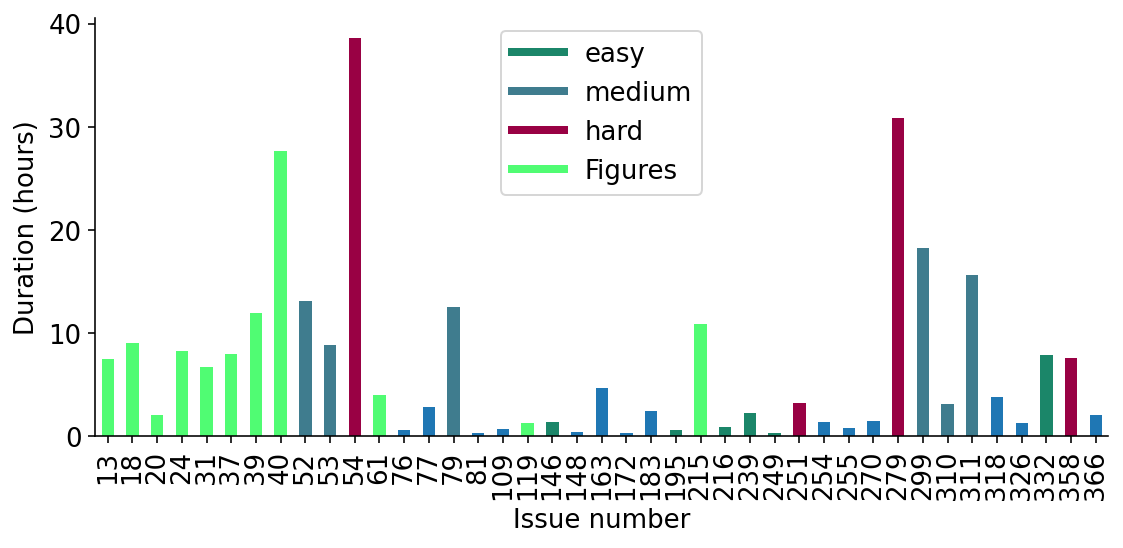

In [1154]:
fig, ax = plt.subplots(figsize=(8, 4))
(issues.query("color != 'tab:gray'")
       [["clocked_hours", "color"]]
       .plot(y="clocked_hours", kind="bar", color=issues.color, ax=ax))

from matplotlib.lines import Line2D

labels = ["easy", "medium", "hard", "Figures"]
custom_lines = [Line2D([0], [0], color=label_color[label], lw=4) for label in labels]
plt.legend(custom_lines, labels)
plt.ylabel("Duration (hours)")
plt.xlabel("Issue number")
plt.tight_layout()
plt.savefig("/Users/gerardoduran/Desktop/duration-issue.png", dpi=150)

In [1065]:
from pyperclip import copy

In [1067]:
issues_summary = issues.dropna(subset=["title"])[["clocked_hours", "title"]]
issues_summary

,clocked_hours,title
issue_number,,
13,7.455833,Convert `unigaussVbDemo` to python
18,9.041667,Convert mcmcGmmDemo to python
20,2.048333,Convert gibbsGaussDemo to python
24,8.228056,Convert `linregOnlineDemoKalman` to python
31,6.675556,Convert `gprDemoMarglik` to python
37,7.985833,Convert casinoDemo to python
39,11.956944,Convert kalmanTrackingDemo to python
40,27.674722,Convert `rbpfManeuverDemo` to python
52,13.052500,extended kalman filtering


In [1071]:
issues_summary.shape

(41, 2)

In [790]:
issues.loc[issues[["clocked_hours"]].idxmax()]

,clocked_hours,created_at,closed_at,title,body,labels,color
issue_number,,,,,,,
54,38.633056,2021-05-24 01:24:49,2021-07-08 14:53:29,EKF/UKF for online learning of an MLP,Use the EKF code from #52 and UKF code from #53 to do online learning of an MLP applied to som...,[hard],#990144


In [797]:
row_issue = gsoc.query("description == 'issue #54'")
row_issue.head()

,id,pid,tid,uid,description,end,updated,dur,user,use_stop,client,project,project_color,project_hex_color,task,billable,is_billable,cur,tags,clocked_hours
start,,,,,,,,,,,,,,,,,,,,
2021-06-21 10:57:29+01:00,2060899065,168628634,None,1670359,issue #54,2021-06-21T11:13:37+01:00,2021-06-21T11:44:38+01:00,968000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[Programming],0.268889
2021-06-21 11:44:51+01:00,2060970211,168628634,None,1670359,issue #54,2021-06-21T12:07:35+01:00,2021-06-21T12:07:36+01:00,1364000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[Programming],0.378889
2021-06-21 13:00:40+01:00,2061091477,168628634,None,1670359,issue #54,2021-06-21T13:09:40+01:00,2021-06-21T13:09:42+01:00,540000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[Programming],0.150000
2021-06-21 14:44:48+01:00,2061298995,168628634,None,1670359,issue #54,2021-06-21T15:16:00+01:00,2021-06-21T15:16:00+01:00,1872000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[Programming],0.520000
2021-06-23 08:20:44+01:00,2064311220,168628634,None,1670359,issue #54,2021-06-23T09:10:15+01:00,2021-06-23T09:37:07+01:00,2971000,Gerardo Durán,True,None,GSoC,0,#465bb3,None,None,False,None,[],0.825278


In [815]:
row_issue.reset_index().start.min()

Timestamp('2021-06-21 10:57:29+0100', tz='Europe/London')

## Pyprobml

In [612]:
pyprobml_repo = g.get_repo("probml/pyprobml")

In [652]:
my_prs = list(pyprobml_repo.get_pulls(state="all", head="gerdm"))

In [749]:
my_prs = [pr for pr in my_prs if pr.user.login == "gerdm"][::-1]
len(my_prs)

39

In [870]:
event = list(my_prs[0].get_issue_events())[0]

In [1074]:
pr_data = []

my_additions, my_deletions = [], []
for pr in tqdm(my_prs):
    entry = {
        "number": pr.number,
        "additions": pr.additions,
        "deletions": pr.deletions,
        "created":  pr.created_at,
        "closed":  pr.closed_at,
        "commits": pr.commits,
        "title": pr.title,
        "body": pr.body,
        "url": pr.url
    }
    pr_data.append(entry)

  0%|          | 0/39 [00:00<?, ?it/s]

In [1075]:
pr_df = pd.DataFrame(pr_data).set_index("number")
pr_df.head()

,additions,deletions,created,closed,commits,title,body,url
number,,,,,,,,
78,423,0,2021-01-07 11:27:31,2021-01-07 22:03:10,1,add gmm and data for old faithful,- Add script that reproduces Bishop fig 9.8 (reference 5.18: mixGaussDemoFaithful)\r\n- Add old...,https://api.github.com/repos/probml/pyprobml/pulls/78
81,33,0,2021-01-08 09:55:20,2021-01-09 23:06:04,1,add gmms singularities diagram,Add script to illustrate singularities in the likelihood function of GMMs (section 5.19)\r\n\r\n...,https://api.github.com/repos/probml/pyprobml/pulls/81
82,77,0,2021-01-12 10:38:28,2021-01-12 15:37:14,1,add parzen-window2 example,* Add Python script that replicates figure 14.7 (PML 1st edition / parzenWindow2)\r\n\r\nThe fol...,https://api.github.com/repos/probml/pyprobml/pulls/82
83,58,0,2021-01-13 08:02:34,2021-01-14 04:44:57,1,add geom_ridge diagram,Replicate `geomRidge.m`digram of section 11.8.\r\nThe script produces the following figure:\r\n\...,https://api.github.com/repos/probml/pyprobml/pulls/83
476,47,0,2021-05-29 10:52:15,2021-05-29 18:49:19,1,add gibbs_gauss_demo.py,Replicate `gibbsGaussDemo.m` for vol 2 book.\r\n\r\nThe script produces the following figure.\r\...,https://api.github.com/repos/probml/pyprobml/pulls/476


In [1128]:
pr_df.shape

(39, 8)

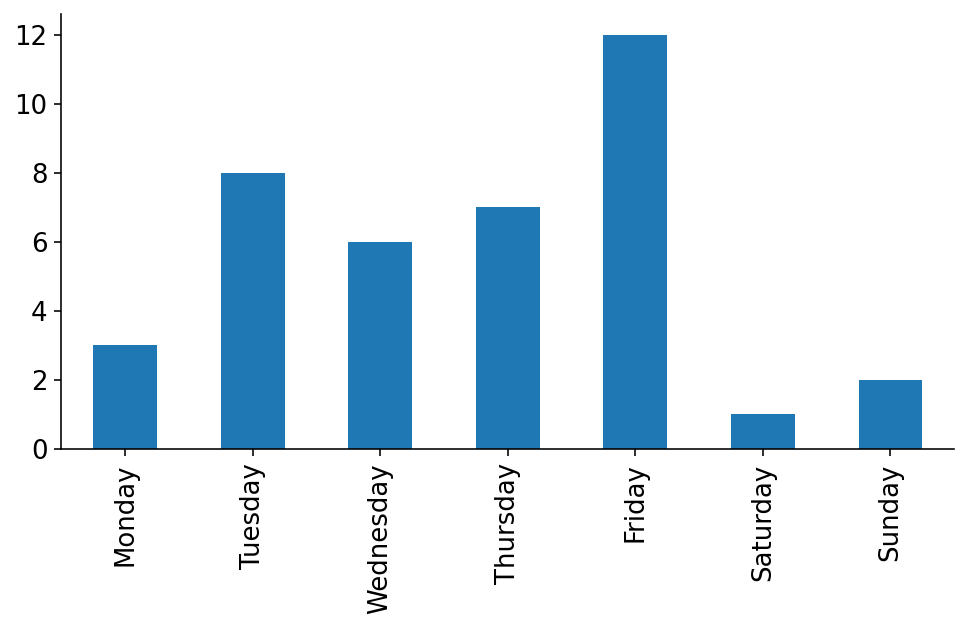

In [1076]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pr_df.created.dt.day_of_week.value_counts().sort_index().plot(kind="bar")
plt.xticks(np.arange(7), weekdays);

<AxesSubplot:xlabel='commits', ylabel='additions'>

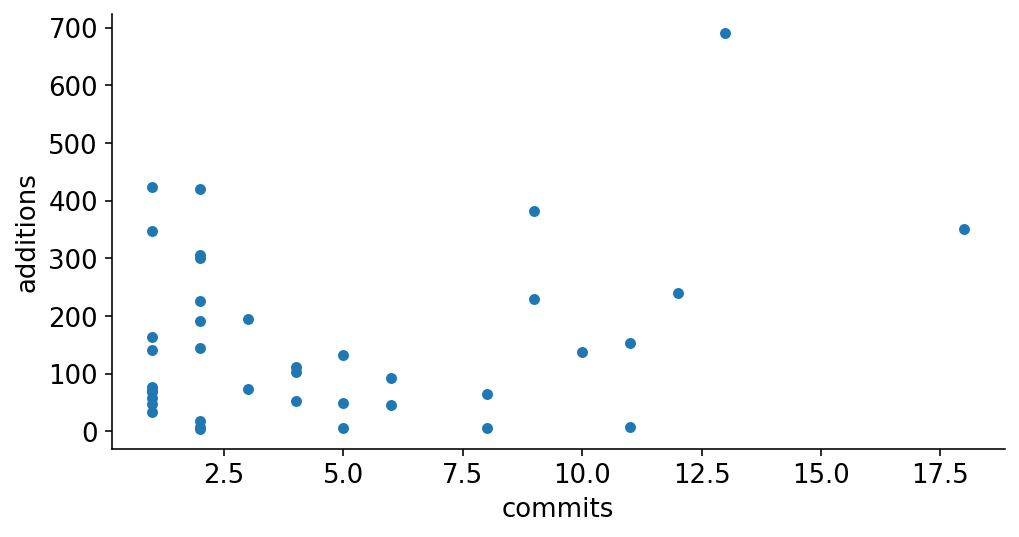

In [1077]:
pr_df.plot(x="commits", y="additions", kind="scatter")

<AxesSubplot:xlabel='number'>

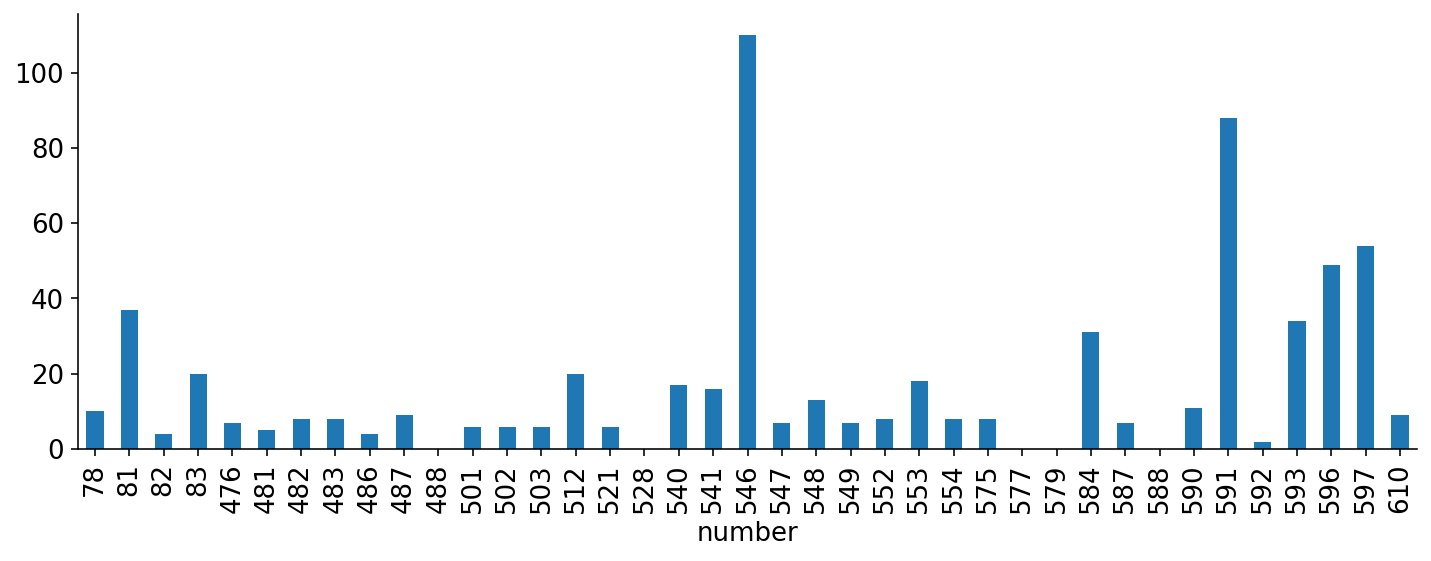

In [1078]:
# Total time to close PR
fig, ax = plt.subplots(figsize=(12, 4))
time_to_close = (pr_df["closed"] - pr_df["created"]).astype("timedelta64[h]")
time_to_close.plot(kind="bar", ax=ax)

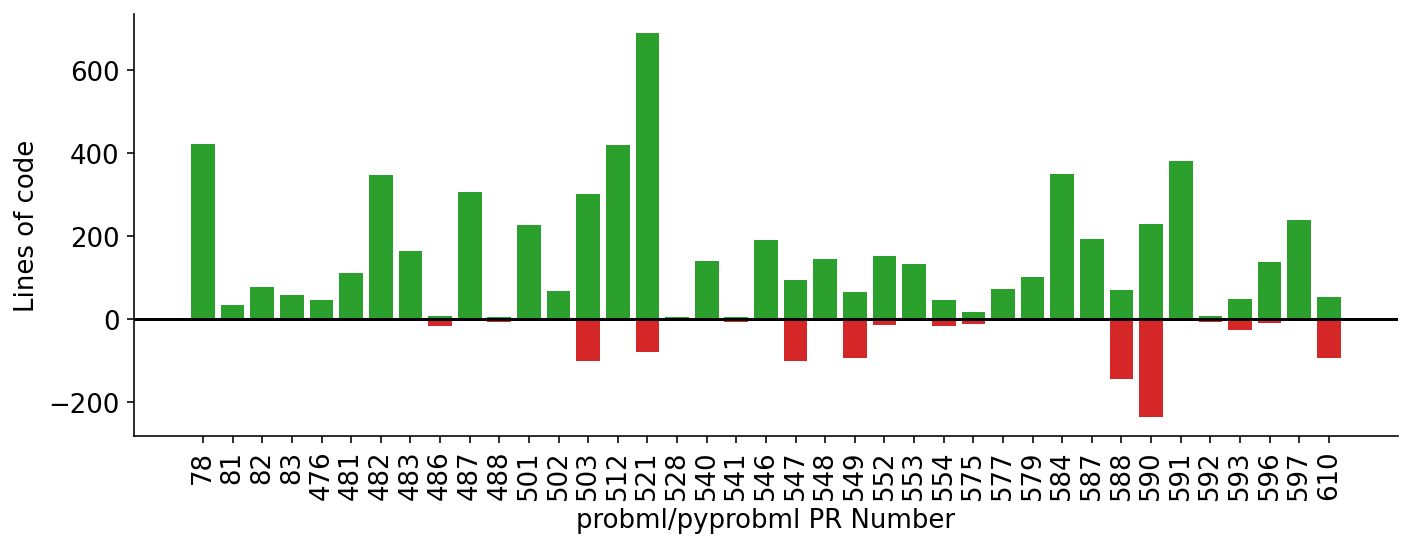

In [1214]:
plt.figure(figsize=(10, 4))

xrange = np.ones_like(my_prs).cumsum() - 1
plt.bar(xrange, pr_df.additions, color="tab:green")
plt.bar(xrange, -pr_df.deletions, color="tab:red")
plt.axhline(y=0, c="black")
plt.xticks(xrange, labels=pr_df.index, rotation=90)
plt.ylabel("Lines of code")
plt.xlabel("probml/pyprobml PR Number")
plt.tight_layout()
plt.savefig("/Users/gerardoduran/Desktop/num-lines-pr.png", dpi=150)s

In [1195]:
# Gross number of lines written
pr_df.additions.sum()

6165

In [1081]:
# Net number of lines written
pr_df.additions.sum() - pr_df.deletions.sum()

5195

----

# Top PRs

In [1101]:
import re

In [1121]:
def render_url(link):
    base_url = "https://github.com/probml/pyprobml/pull/"
    pr_num = re.search("([0-9]+)$", link)[0]
    name = f"[PR {pr_num}]({base_url}{pr_num})"
    return name

In [1127]:
table = pr_df.sort_values("closed")[["title", "additions", "url"]]
copy(table.assign(url=table.url.apply(render_url)).set_index("url").to_markdown())

# PR #483

In [1055]:
Markdown(pr_df.loc[483].body)

## Description

Metropolis Hastings (MH) Sampling from a mixture of two 1d Gaussians using a 1d Gaussian proposal with different sigma and Gibbs sampling.

### Figure Number

15.1, 15.5, 15.22.

### Figures

**Gibbs sampling**

![image](https://user-images.githubusercontent.com/4108759/120275041-a268bf00-c2a8-11eb-966a-4fc58b029f72.png)

![image](https://user-images.githubusercontent.com/4108759/120275712-a6e1a780-c2a9-11eb-9123-88afeac5365d.png)


**Metropolis-Hastings**
![image](https://user-images.githubusercontent.com/4108759/120275839-d0023800-c2a9-11eb-8802-ecd5f766fa73.png)


**Autocorrelation functions**
![image](https://user-images.githubusercontent.com/4108759/120275072-ac8abd80-c2a8-11eb-8258-45daee193ad4.png)


### Issue 

Closes #18 


## Checklist:

- [x] Performed a self-review of the code
- [x] Tested on Google Colab.

## Potential problems/Important remarks
* Important to pip install `matplotlib==3.4.2` or older for correct display of 3d plots


# PR #521

In [946]:
Markdown(pr_df.loc[521].body)

## Description

Current KF example is discrete and EKF example is continuous. This is confusing. To clarify this, we create two classes per Kalman Filter implementation: continuous and discrete. The structure is the following.

|            | KF                                | EKF                              |
|------------|-----------------------------------|----------------------------------|
| Discrete   | `KalmanFilter`                    | `ExtendedKalmanFilter`           |
| Continuous | `ContinuousKalmanFilter`          | `ContinuousExtendedKalmanFilter` |
| filename   | `linear_dynamical_systems_lib.py` | `dynamical_systems_lib.py`       |


## To-do
- [x] Create `ContinuousKalmanFilter` (See #170)
- [x] Circle example using `ContinuousKalmanFilter` class (See #148)
- [x] Rename `LinearDynamicalSystem` -> `KalmanFilter` class
    - Update examples accordingly
    - Rename `kalman_filter` for `filter`
    - Rename `kalman_smoother` for `smooth`
- [x] Rename `ExtendedKalmanFilter ` -> `ContinuousExtendedKalmanFilter`
    - Rename module `simulate` -> `sample`
    - In `sample` module, pass `key` first (as per JAX's convention)
- [x] Create `ExtendedKalmanFilter` for discrete observations
- [x] Create example using `ExtendedKalmanFilter`


### Figures

Created a circle KF demo


![](https://user-images.githubusercontent.com/4108759/122192100-3cc12900-ce8b-11eb-9d81-1c526a239d87.png)


Furthermore, we created a UKF demo

![](https://user-images.githubusercontent.com/4108759/122440884-e809d500-cf94-11eb-954e-2308465e3b6d.png)

And a comparison against EKF demo 


![](https://user-images.githubusercontent.com/4108759/122567940-1e9d2980-d041-11eb-9924-a8f72ecec02c.png)


# PR #577

In [1057]:
Markdown(pr_df.loc[577].body)

## Description

* Create UKF + MPL `.mp4` animation

### Figures

https://user-images.githubusercontent.com/4108759/125843287-1ac08592-6544-4def-b86b-876a633952fc.mp4

### Issue 

Closes [Issue 255](https://github.com/probml/hermes/issues/255) in Hermes

In [1048]:
url = "https://user-images.githubusercontent.com/4108759/125843287-1ac08592-6544-4def-b86b-876a633952fc.mp4"
Video(url, width=500)

## References
* [Detailed Report](https://github.com/toggl/toggl_api_docs/blob/master/reports/detailed.md)
* [Toggl Reports](https://github.com/toggl/toggl_api_docs/blob/master/reports.md)